Mount google drive

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Import necessary libraries 

In [6]:
from os import listdir
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


In [7]:
# Load the vgg16 model
base_model = VGG16(include_top=True)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Remove the last layer of VGG16 as we don't need it and use the second last 
# layer fc2 as the output layer  
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Extract the features from all the images 

In [9]:
features = dict()
for file in listdir('/content/drive/My Drive/AI_caption/Flickr8k_Dataset/'):
    img_path = '/content/drive/My Drive/AI_caption/Flickr8k_Dataset/' + file
    img = load_img(img_path, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to VGG16 input format
    fc2_features = model.predict(x)
    
    name_id = file.split('.')[0] #take the file name and use as id in dict
    features[name_id] = fc2_features

dump(features, open('features_extracted.pkl', 'wb')) #cannot use JSON because ndarray is not JSON serializable

Loading Data Sets Image ID

In [10]:
def load_data_set_ids(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    dataset = list()
    for image_id in text.split('\n'):
        if len(image_id) < 1:
            continue
            
        dataset.append(image_id)
    
    return set(dataset)
training_set = load_data_set_ids('/content/drive/My Drive/AI_caption/Flickr8k_text/Flickr_8k.trainImages.txt')
dev_set = load_data_set_ids('/content/drive/My Drive/AI_caption/Flickr8k_text/Flickr_8k.devImages.txt')
test_set = load_data_set_ids('/content/drive/My Drive/AI_caption/Flickr8k_text/Flickr_8k.testImages.txt')

Captions clean up:
-remove all  numbers and punctuations 
-lower case only 
-remove words containing single chars 
-add 'START' and 'END' 

In [11]:
import string
filename = '/content/drive/My Drive/AI_caption/Flickr8k_text/Flickr8k.token.txt'
file = open(filename, 'r')
token_text = file.read()
file.close()

translator = str.maketrans("", "", string.punctuation) #translation table that maps all punctuation to None
image_captions = dict()
image_captions_train = dict()
image_captions_dev = dict()
image_captions_test = dict()
image_captions_other = dict()
corpus = list() #corpus used to train tokenizer
corpus.extend(['<START>', '<END>', '<UNK>']) #add SOS and EOS to list first

max_imageCap_len = 0

for line in token_text.split('\n'): # first split on new line
    tokens = line.split(' ') #split on white space, the first segment is 1000268201_693b08cb0e.jpg#0, the following segements are caption texts
    if len(line) < 2:
        continue
    image_id, image_cap = tokens[0], tokens[1:] #use the first segment as image id, the rest as caption
    image_id = image_id.split('#')[0] #strip out #0 from filename
    image_cap = ' '.join(image_cap) #join image caption together again

    image_cap = image_cap.lower() #change to lower case
    image_cap = image_cap.translate(translator) #take out punctuation using a translation table
    
    image_cap = image_cap.split(' ') #split string here because following two methods works on word-level best
    image_cap = [w for w in image_cap if w.isalpha()] #keep only words that are all letters
    image_cap = [w for w in image_cap if len(w)>1]
    image_cap = '<START> ' + ' '.join(image_cap) + ' <END>' #add sentence start/end; note syntax: separator.join()
    
    #update maximum caption length
    if len(image_cap.split()) > max_imageCap_len:
        max_imageCap_len = len(image_cap.split())
    
    #add to dictionary
    if image_id not in image_captions:
        image_captions[image_id] = list() #creat a new list if it does not yet exist
    image_captions[image_id].append(image_cap)
    
    #add to train/dev/test dictionaries
    if image_id in training_set:
        if image_id not in image_captions_train:
            image_captions_train[image_id] = list() #creat a new list if it does not yet exist
        image_captions_train[image_id].append(image_cap)
        corpus.extend(image_cap.split()) #add only training words to corpus to train tokenlizer
        
    elif image_id in dev_set:
        if image_id not in image_captions_dev:
            image_captions_dev[image_id] = list() #creat a new list if it does not yet exist
        image_captions_dev[image_id].append(image_cap)
        
    elif image_id in test_set:
        if image_id not in image_captions_test:
            image_captions_test[image_id] = list() #creat a new list if it does not yet exist
        image_captions_test[image_id].append(image_cap)
    else:
        if image_id not in image_captions_other:
            image_captions_other[image_id] = list() #creat a new list if it does not yet exist
        image_captions_other[image_id].append(image_cap)

caption_train_tokenizer = Tokenizer() #initialize tokenizer
caption_train_tokenizer.fit_on_texts(corpus) #fit tokenizer on training data
    
fid = open("image_captions.pkl","wb")
dump(image_captions, fid)
fid.close()

fid = open("image_captions_train.pkl","wb")
dump(image_captions_train, fid)
fid.close()

fid = open("image_captions_dev.pkl","wb")
dump(image_captions_dev, fid)
fid.close()

fid = open("image_captions_test.pkl","wb")
dump(image_captions_test, fid)
fid.close()

fid = open("image_captions_other.pkl","wb")
dump(image_captions_other, fid)
fid.close()

fid = open("caption_train_tokenizer.pkl","wb")
dump(caption_train_tokenizer, fid)
fid.close()

fid = open("corpus.pkl","wb")
dump(corpus, fid)
fid.close()

corpus_count=Counter(corpus)
fid = open("corpus_count.pkl","wb")
dump(corpus_count, fid)
fid.close()

print("size of data =", len(image_captions), "size of training data =", len(image_captions_train), "size of dev data =", len(image_captions_dev), "size of test data =", len(image_captions_test), "size of unused data =", len(image_captions_other))
print("maximum image caption length =",max_imageCap_len)

size of data = 8092 size of training data = 6000 size of dev data = 1000 size of test data = 1000 size of unused data = 92
maximum image caption length = 33


Use Glove word emdeddings to encode captions into 50D word vectors 

In [12]:
embeddings_index = dict()
fid = open('/content/drive/My Drive/AI_caption/glove.6B/glove.6B.50d.txt' ,encoding="utf8")
for line in fid:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
fid.close()
EMBEDDING_DIM = 50
word_index = caption_train_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embed_vector
        
fid = open("embedding_matrix.pkl","wb")
dump(embedding_matrix, fid)
fid.close()

Generating training data for progressive loading 

In [14]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0] #[0] is used to take out the extra dim. This changes from text to a number
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            # import pdb; pdb.set_trace()
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [15]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, batch_size, vocab_size):
    # loop for ever over images
    current_batch_size=0
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            if current_batch_size == 0:
                X1, X2, Y = list(), list(), list()
            
            imageFeature_id = key.split('.')[0]
            photo = photos[imageFeature_id][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            #in_img = np.squeeze(in_img)
            X1.extend(in_img)
            X2.extend(in_seq)
            Y.extend(out_word)
            current_batch_size += 1
            if current_batch_size == batch_size:
                current_batch_size = 0
                yield [np.array(X1), np.array(X2)], np.array(Y) 

In [16]:
from pickle import load
fid = open('features_extracted.pkl', 'rb')
image_features = load(fid)
fid.close()

In [17]:
# test the data generator
caption_max_length = 33
batch_size = 1
vocab_size = 7057
generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 33)
(47, 7057)


Model definition 

In [19]:
from keras.layers.merge import concatenate
def define_model_concat(vocab_size, max_length, embedding_matrix):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    image_feature = Dropout(0.5)(inputs1)
    image_feature = Dense(256, activation='relu')(image_feature)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    language_feature = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
    #Embedding(vocab_size, 256, mask_zero=True)(inputs2) #<<<<<< fix me, add pretrianed embedding
    language_feature = Dropout(0.5)(language_feature)
    language_feature = LSTM(256)(language_feature)
    # decoder model
    output = concatenate([image_feature, language_feature])
    output = Dense(256, activation='relu')(output)
    output = Dense(vocab_size, activation='softmax')(output)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_concat.png', show_shapes=True)
    return model

fid = open("embedding_matrix.pkl","rb")
embedding_matrix = load(fid)
fid.close()

caption_max_length = 33
vocab_size = 7506
post_rnn_model_concat = define_model_concat(vocab_size, caption_max_length, embedding_matrix)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 50)       375300      input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

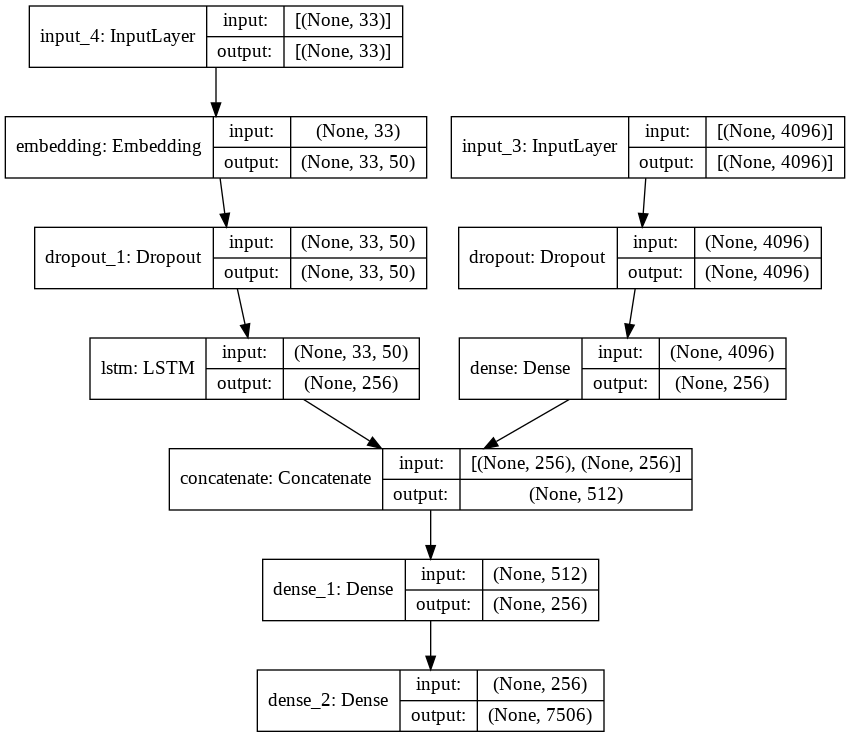

In [20]:
from keras.utils import plot_model
plot_model(post_rnn_model_concat, to_file='model_plot.png', show_shapes=True)

Training model Epoch 0-10 

In [21]:
#Training Model
#We use the progressive loading data generator to generate the training data on-the-fly. For each batch, we generate training data from 3 images.

fid = open("features_extracted.pkl","rb")
image_features = load(fid)
fid.close()

fid = open("caption_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(fid)
fid.close()

fid = open("image_captions_train.pkl","rb")
image_captions_train = load(fid)
fid.close()

fid = open("image_captions_dev.pkl","rb")
image_captions_dev = load(fid)
fid.close()

caption_max_length = 33
batch_size = 100
vocab_size = 7506
#generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)

#train 1
batch_size = 3
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

epochs = 10

for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	post_rnn_model_concat.save('modelConcat_1_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 109s 18ms/step - loss: 2.9495 - acc: 0.3275


Epoch 10-20 

In [22]:
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#train 2
batch_size = 3
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

epochs = 10

for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard])
	# save model
	post_rnn_model_concat.save('modelConcat_2_' + str(i) + '.h5')

6000/6000 [==============================] - 115s 19ms/step - loss: 2.8582 - acc: 0.3386


Epoch 20-30 

In [23]:
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#train 3
batch_size = 3
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

epochs = 10

for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard])
	# save model
	post_rnn_model_concat.save('modelConcat_2_' + str(i) + '.h5')

6000/6000 [==============================] - 113s 19ms/step - loss: 2.8352 - acc: 0.3431


Epoch 30-40 

In [24]:
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#train 4
batch_size = 6
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

epochs = 10

for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard])
	# save model
	post_rnn_model_concat.save('modelConcat_3_' + str(i) + '.h5')

6000/6000 [==============================] - 214s 36ms/step - loss: 2.6840 - acc: 0.3629


Epoch 40-50 

In [25]:
#train 5
batch_size = 6

epochs = 10

steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)


In [26]:
for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	post_rnn_model_concat.save('modelConcat_4_' + str(i) + '.h5')

6000/6000 [==============================] - 221s 37ms/step - loss: 2.6472 - acc: 0.3684


Creating captions 

In [27]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt

In [28]:
base_model = VGG16(include_top=True)
feature_extract_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [29]:
def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to VGG16 input format
    fc2_features = model.predict(x)
    return fc2_features
# load the tokenizer
caption_train_tokenizer = load(open('caption_train_tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33
# load the model
pred_model = load_model('modelConcat_4_9.h5')

In [30]:
def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    in_text = '<START>'
    caption_text = list()
    for i in range(max_length):
            # integer encode input sequence
            sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next word
            model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
            # convert probability to integer
            word_index = argmax(model_softMax_output)
            # map integer to word
            word = caption_train_tokenizer.index_word[word_index]
            #print(word)
            # stop if we cannot map the word
            if word is None:
                break
            # append as input for generating the next word
            in_text += ' ' + word
            # stop if we predict the end of the sequence
            if word != 'end':
                caption_text.append(word)
            if word == 'end':
                break
    return caption_text

Test model on novel images from a google drive folder

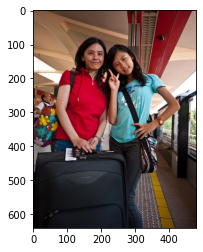

Caption:
_____________________________________
man in blue shirt and jean hat is sitting on bench


In [58]:
pic ='pic10.jpg'
novel_images_path = '/content/'
x=plt.imread(novel_images_path+pic)
caption_image_fileName = 'pic10.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
plt.imshow(x)
plt.show()
print("Caption:",)
print("_____________________________________")
print(' '.join(caption))

Beam search implementation to compare with greedy search 

In [59]:
def flatten(lst):
    return sum( ([x] if not isinstance(x, list) else flatten(x) for x in lst), [] )
def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['<START>'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])


    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['end']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]


        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['end']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['end']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))


    return final_caption, most_likely_prob

Test on pictures and print captions and BLEU scores for BEAM K=10 

In [64]:
photo = extract_feature(feature_extract_pred_model, 'pic10.jpg')
vocab_size = 7506
beam_width = 10
max_length = 33
caption, prob = generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length,vocab_size,beam_width)
print(caption)
print(prob)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


['group man man is riding motorcycle on dirt bike', 'person group of people are riding horses in race', 'group man man is riding motorcycle on dirt road', 'group man man is riding his bicycle down the street', 'person group of people are riding horses on dirt road', 'person group of people are riding offroad on dirt track', 'people officers are riding horses on dirt road', 'people officers are riding horses on dirt track', 'person group of people are riding horses on dirt track', 'group man man is riding his bicycle down the road']
[-1.2908856 -1.2798772 -1.2762735 -1.2238301 -1.2113031 -1.2020426
 -1.1983865 -1.1652853 -1.1581838 -1.1436843]


In [65]:
post_rnn_model_concat.save('/content/drive/My Drive/modelConcat_4_' + str(i) + '.h5')

Evaluation of results 
-import everything 
-implement BLEU 
-test on 1000 test images and print BLEU scores

In [66]:
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
from numpy import argmax

In [67]:
fid = open("/content/features_extracted.pkl","rb")
image_features = load(fid)
fid.close()

fid = open("caption_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(fid)
fid.close()

fid = open("image_captions_test.pkl","rb")
image_captions_test = load(fid)
fid.close()

# pre-define the max sequence length (from training)
max_length = 33
# load the model
pred_model = load_model('modelConcat_4_9.h5')
#pred_model = load_model('model_3_0.h5')

base_model = VGG16(include_top=True) #define the image feature extraction model
feature_extract_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [68]:
image_captions_candidate = dict()
for image_fileName, reference_captions in image_captions_test.items():
    image_fileName_feature = image_fileName.split('.')[0]
           
    photo = features[image_fileName_feature]
    image_captions_candidate[image_fileName] = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
    
fid = open("test_captions_post_concat","wb")
dump(image_captions_candidate, fid)
fid.close()

In [69]:
fid = open('features_extracted.pkl','rb')
features = load(fid)
fid.close()

vocab_size = 7506
beam_width = 5
max_length = 33
final_caption, most_likely_prob = generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width)

image_captions_candidate_beam5 = dict()
for image_fileName, reference_captions in image_captions_test.items():
    image_fileName_feature = image_fileName.split('.')[0]
           
    photo = features[image_fileName_feature]
    image_captions_candidate_beam5[image_fileName], _ = generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width)
    #print(image_captions_candidate_beam5[image_fileName])
    
fid = open("test_captions_concate_beam5_post","wb")
dump(image_captions_candidate_beam5, fid)
fid.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


BLEU

In [70]:
#greedy bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from pickle import load

fid = open("test_captions_post_concat","rb")
image_captions_candidate = load(fid)
fid.close()

fid = open("test_captions_concate_beam5_post","rb")
image_captions_candidate_beam5 = load(fid)
fid.close()

fid = open("image_captions_test.pkl","rb")
image_captions_test = load(fid)
fid.close()

chencherry = SmoothingFunction()

bleu_score = dict()
bleu_score_beam5 = dict()
for image_fileName, reference_captions in image_captions_test.items():
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(cap.split()[1:-1])
    
    bleu_score[image_fileName] = sentence_bleu(ref_cap_reformat, image_captions_candidate[image_fileName], smoothing_function=chencherry.method1)
    bleu_score_beam5[image_fileName] = sentence_bleu(ref_cap_reformat, list(image_captions_candidate_beam5[image_fileName][-1].split()), smoothing_function=chencherry.method1)
    
    
#print(bleu_score)

Bleu score for greedy search

In [71]:
import numpy as np
bleu_score_array = np.fromiter(bleu_score.values(), dtype=float)
print('mean bleu='+str(np.mean(bleu_score_array)) + '; median bleu='+str(np.median(bleu_score_array))+'; max bleu='+str(np.max(bleu_score_array))+'; min bleu='+str(np.min(bleu_score_array))+'; std bleu='+str(np.std(bleu_score_array)))



mean bleu=0.08329028106942474; median bleu=0.04933122379117313; max bleu=1.0; min bleu=0.0; std bleu=0.10724231943139316


Bleu score for beam search with width=5

In [72]:
bleu_score_beam_5array = np.fromiter(bleu_score_beam5.values(), dtype=float)
print('mean beam5 bleu='+str(np.mean(bleu_score_beam_5array)) + '; median beam5 bleu='+str(np.median(bleu_score_beam_5array))+'; max beam5 bleu='+str(np.max(bleu_score_beam_5array))+'; min beam5 bleu='+str(np.min(bleu_score_beam_5array))+'; std beam5 bleu='+str(np.std(bleu_score_beam_5array)))

mean beam5 bleu=0.07370933431558757; median beam5 bleu=0.04380241859426539; max beam5 bleu=0.6606328636027614; min beam5 bleu=0.0; std beam5 bleu=0.08888932055929587


ROUGE - to be implemented in the future for better evaluation 

In [ ]:
pip install rouge

In [ ]:
#greedy rouge
from rouge import rouge

rouge_score = dict()
for image_fileName, reference_captions in image_captions_test.items():
    cand=[' '.join(image_captions_candidate[image_fileName])]
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    
    rouge_score[image_fileName] = rouge(cand, ref_cap_reformat)

#print(rouge_score)

In [ ]:
#rouge beam5
from rouge import rouge

rouge_score_beam5 = dict()
for image_fileName, reference_captions in image_captions_test.items():
    cand=[image_captions_candidate_beam5[image_fileName][-1]]
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    
    rouge_score_beam5[image_fileName] = rouge(cand, ref_cap_reformat)

#print(rouge_score)

In [ ]:
num_test = len(rouge_score_beam5)


rouge_1_f_score_beam5_array = np.zeros(num_test)
rouge_2_f_score_beam5_array = np.zeros(num_test)
rouge_l_f_score_beam5_array = np.zeros(num_test)

idx = 0
for val in rouge_score_beam5.values():
    rouge_1_f_score_beam5_array[idx] = val['rouge_1/f_score']
    rouge_2_f_score_beam5_array[idx] = val['rouge_2/f_score']
    rouge_l_f_score_beam5_array[idx] = val['rouge_l/f_score']
    idx += 1
    

rouge_1_f_score_array = np.zeros(num_test)
rouge_2_f_score_array = np.zeros(num_test)
rouge_l_f_score_array = np.zeros(num_test)

idx = 0
for val in rouge_score.values():
    rouge_1_f_score_array[idx] = val['rouge_1/f_score']
    rouge_2_f_score_array[idx] = val['rouge_2/f_score']
    rouge_l_f_score_array[idx] = val['rouge_l/f_score']
    idx += 1